### Import libraries

In [36]:
import numpy as np
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Activation, Dropout, Flatten, Dense
# %pip install visualkeras
import visualkeras as vk
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import glob
import os

## Prepare the data

In [19]:
# Model / data parameters
img_width, img_height = 28, 28
epochs = 15
batch_size = 16
input_shape = (28, 28, 1)
num_classes = 10

notMNIST_load_data is a function that loads the notMNIST dataset. It returns three tuples containing the training, validation and test data. Each tuple is formed by a numpy array containing the images and a numpy array containing the labels (0 to 9).

In [20]:
def notMNIST_load_data() : 
    data_dir_letters = 'data/notMNIST_small'

    nb_letters = len(os.listdir(data_dir_letters))
    if nb_letters != num_classes:
        raise ValueError('The number of classes is not equal to the number of letters in the folder')

    x_train = []
    y_train = []
    x_val = []
    y_val = []
    x_test = []
    y_test = []

    # we get the number of samples in the smallest class
    min_nb_samples = float('inf')
    for letter in os.listdir(data_dir_letters):
        nb_samples = len(os.listdir(os.path.join(data_dir_letters, letter)))
        min_nb_samples = min(min_nb_samples, nb_samples)

    # 80% of the data is used for training
    # 10% for validation
    # 10% for testing
    nb_train_samples = int(min_nb_samples * 0.7)
    nb_validation_samples = int(min_nb_samples * 0.1)
    nb_test_samples = nb_samples - nb_train_samples - nb_validation_samples

    # for each letter folder, we copy the images in the train, validation or test tuple and the label
    # TODO : randomize the order of the images would be better ?
    for letter in os.listdir(data_dir_letters):
        index = 0

        for image in glob.iglob(os.path.join(data_dir_letters, letter, "*.png")):

            if index < nb_train_samples:
                pixels_array = mpimg.imread(image)
                x_train.append(pixels_array)
                y_train.append(ord(letter) - 65)
            elif index < nb_train_samples + nb_validation_samples:
                pixels_array = mpimg.imread(image)
                x_val.append(pixels_array)
                y_val.append(ord(letter) - 65)
            elif index < nb_train_samples + nb_validation_samples + nb_test_samples:
                pixels_array = mpimg.imread(image)
                x_test.append(pixels_array)
                y_test.append(ord(letter) - 65)
            index += 1
    
    return (np.array(x_train), np.array(y_train)), (np.array(x_test), np.array(y_test)), (np.array(x_val), np.array(y_val))

In [21]:
# load the data, split between train and test sets
# (x_train, y_train), (x_test, y_test) = notMNIST_load_data()
(x_train, y_train), (x_test, y_test), (x_val, y_val) = notMNIST_load_data()

In [22]:
# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
x_val = x_val.astype("float32") / 255

In [23]:
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_val = np.expand_dims(x_val, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")
print(x_val.shape[0], "validation samples")

x_train shape: (13100, 28, 28, 1)
13100 train samples
3750 test samples
1870 validation samples


In [24]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

## Build the model

In [223]:
def build_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model

In [224]:
def build_model_LeNet():
    # LeNet-5 architecture
    model = Sequential()
    
    model.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(AveragePooling2D())

    model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
    model.add(AveragePooling2D())

    model.add(Flatten())

    model.add(Dense(units=120, activation='relu'))
    model.add(Dense(units=84, activation='relu'))
    model.add(Dense(units=num_classes, activation = 'softmax'))

    return model

In [ ]:
def build_model_LeNet_new():
    # LeNet-5 architecture
    model = Sequential()
    
    model.add(Conv2D(filters=6, kernel_size=(5, 5), activation='tanh', input_shape=input_shape))
    model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(filters=16, kernel_size=(5, 5), activation='tanh'))
    model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Flatten())

    model.add(Dense(units=120, activation='tanh'))
    model.add(Dense(units=84, activation='tanh'))
    model.add(Dense(units=num_classes, activation = 'softmax'))

    return model

In [25]:
def build_model_LeNet_best():
    # LeNet-5 architecture found in a paper
    model = Sequential()
    
    model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(strides=2))

    model.add(Conv2D(filters=48, kernel_size=(5, 5), padding='valid', activation='relu'))
    model.add(MaxPooling2D(strides=2))

    model.add(Flatten())

    model.add(Dense(units=256, activation='relu'))
    model.add(Dense(units=84, activation='relu'))
    model.add(Dense(units=num_classes, activation = 'softmax'))

    return model

In [26]:
# get the model
model = build_model_LeNet_best()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 48)        38448     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 5, 5, 48)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 1200)              0         
                                                                 
 dense_3 (Dense)             (None, 256)              

In [27]:
# Compile the model
model.compile(
    loss="categorical_crossentropy", 
    optimizer="adam", 
    metrics=["accuracy"]
)

### Visualize the model

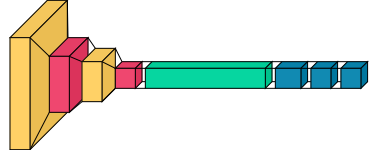

In [32]:
vk.layered_view(model)

## Data augmentation

In [28]:
datagen = ImageDataGenerator(
            rotation_range=10, 
            width_shift_range=0.1, 
            height_shift_range=0.1, 
            zoom_range=0.1)
datagen.fit(x_train)

## Train the model

In [29]:
# model.fit(x_train, y_train, batch_size=batch_size, epochs=30, steps_per_epoch=len(x_train) // batch_size)
model.fit(datagen.flow(x_train, y_train, batch_size=100), epochs=30, steps_per_epoch=len(x_train) // 100, validation_data=(x_val, y_val))

Epoch 1/30
131/131 [==============================] - 8s 55ms/step - loss: 1.8070 - accuracy: 0.3557 - val_loss: 0.9686 - val_accuracy: 0.7289
Epoch 2/30
131/131 [==============================] - 8s 61ms/step - loss: 1.0525 - accuracy: 0.6767 - val_loss: 0.6548 - val_accuracy: 0.8214
Epoch 3/30
131/131 [==============================] - 7s 55ms/step - loss: 0.8291 - accuracy: 0.7530 - val_loss: 0.4971 - val_accuracy: 0.8663
Epoch 4/30
131/131 [==============================] - 8s 58ms/step - loss: 0.7091 - accuracy: 0.7955 - val_loss: 0.4123 - val_accuracy: 0.8909
Epoch 5/30
131/131 [==============================] - 8s 59ms/step - loss: 0.6108 - accuracy: 0.8240 - val_loss: 0.3657 - val_accuracy: 0.9043
Epoch 6/30
131/131 [==============================] - 8s 63ms/step - loss: 0.5750 - accuracy: 0.8296 - val_loss: 0.3391 - val_accuracy: 0.9086
Epoch 7/30
131/131 [==============================] - 8s 62ms/step - loss: 0.5304 - accuracy: 0.8441 - val_loss: 0.3126 - val_accuracy: 0.9150

## Evaluate the trained model

In [30]:
score = model.evaluate(x_test, y_test, batch_size=batch_size)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

  1/235 [..............................] - ETA: 7s - loss: 1.2901e-04 - accuracy: 1.0000

235/235 [==============================] - 1s 2ms/step - loss: 0.2286 - accuracy: 0.9293
Test loss: 0.22855401039123535
Test accuracy: 0.9293333292007446


In [38]:
# Perform Prediction
y_pred = model.predict(x_test)

118/118 [==============================] - 0s 3ms/step


### Show Confusion Matrix

In [54]:
def plot_confusion_matrix(y_test, y_pred, nb_classes):
    classes = np.arange(nb_classes)
    classes_print = [chr(i) for i in range(65, 65 + nb_classes)]
    cm = confusion_matrix(y_test, y_pred, labels=classes)
    cm_df = pd.DataFrame(cm, index=classes_print, columns=classes_print)

    plt.figure(1, figsize=(16, 8))
    sns.set(font_scale=1.5, color_codes=True, palette='deep')
    sns.heatmap(cm_df, annot=True, annot_kws={'size': 16}, fmt='d', cmap='YlGnBu')
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.title('Confusion Matrix')
    plt.show()

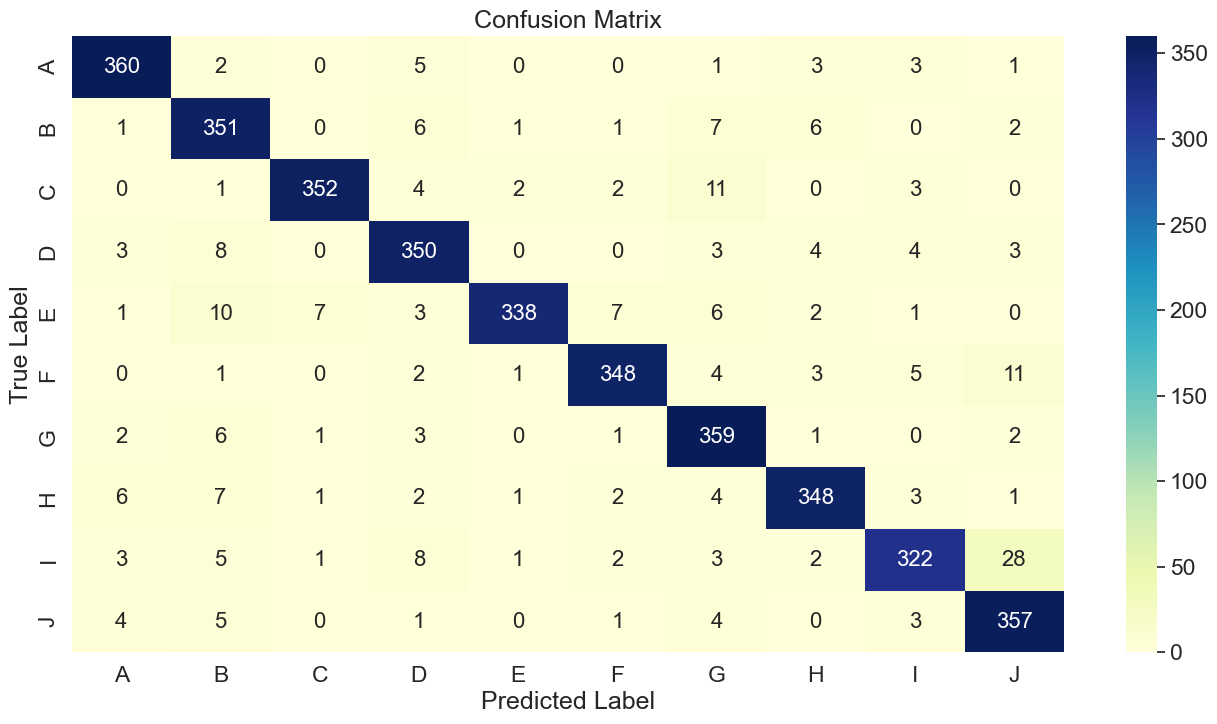

In [57]:
plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), 10)

### Results - used to find the best architecture and hyperparameters
* Architecture LeNet-5 \
50 epochs, batch size 128 \
Epoch 50/50 - loss: 0.3308 - accuracy: 0.8945 \
Test loss: 2.313185691833496 \
Test accuracy: 0.649066686630249 \

* Architecture LeNet-5 \
15 epochs, batch size 16 \
Epoch 15/15 - loss: 0.4077 - accuracy: 0.8687 \
Test loss: 2.001655101776123 \
Test accuracy: 0.7760000228881836 \

* Architecture LeNet-5 \
15 epochs, batch size 16 \
Convolution : kernel_size=(5, 5), activation='relu' \
Epoch 15/15 - loss: 0.2376 - accuracy: 0.9270 \
Test loss: 1.7583626508712769 \
Test accuracy: 0.8191999793052673 \

* Architecture LeNet-5_new \
15 epochs, batch size 16 \
Convolution : kernel_size=(5, 5), activation='tanh' \
Pooling : pool_size=(2, 2), strides=(2, 2) \
Epoch 15/15 - loss: 0.2376 - accuracy: 0.9270 \
Test loss: 1.7583626508712769   \
Test accuracy: 0.8191999793052673 \

* Architecture LeNet-5_best (from paper)  \
30 epochs, batch size 16, steps_per_epoch=len(x_train) // batch_size \
Epoch 30/30 - loss: 0.0706 - accuracy: 0.9753 \
Test loss: 0.47975218296051025 \
Test accuracy: 0.909333348274231 \

* Architecture LeNet-5_best (from paper) with data augmentation \
30 epochs, batch size 100, steps_per_epoch=len(x_train) // 100 \
Epoch 30/30 - loss: 0.2406 - accuracy: 0.9232 \
Test loss: 0.24029511213302612  \
Test accuracy: 0.9306666851043701 \

* Architecture LeNet-5_best (from paper) with data augmentation and validation \
30 epochs, batch size 100, steps_per_epoch=len(x_train) // 100 \
Epoch 30/30 - loss: 0.2584 - accuracy: 0.9195 \
Test loss: 0.22855401039123535  \
Test accuracy: 0.9293333292007446 \

### Papers :
https://www.kaggle.com/code/curiousprogrammer/lenet-5-cnn-with-keras-99-48 \
https://patilswaraj22.medium.com/keras-based-implementation-of-lenet-5-db678b11c61a (For the confusion matrix)